<a href="https://colab.research.google.com/github/Algos-Superficialis/Webcomp2024/blob/main/Letzte_Aufgabe_Hand_Eric_Harloff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Endaufgabe Digital Image Processing zum 28.01.25

Eric L. Harloff / 20236313

Vorwort ∇

Wenn sie den kompletten Hands4DIP Ordner einfach in die Sample Data reinladen (Was automatisch passieren sollte beim Download), müssen sie nichts weiter tätigen, es sollte alles reibungslos funktonieren.

Ausserdem müssen sie den Code von oben nach unten einmal Komplett ausführen.
Erstens wegen !PIP und zweites damit image_data_list (Neue Liste für die Image Daten) und features_list (Liste von den Features für Kmeans) ausgeführt werden.

Aufgabe =  Die Komplette Pipeline für Image Processing einmal aufbauen aus dem Hands4DIP Ordner


In [23]:
# Vielleicht ein bisschen umständlich, dass man bei jedem neuen Import den Block neu ausführen muss,
# ich wollte es jedoch sauber halten und keine Imports in den eigentlichen Code Blöcken haben.
!pip install opencv-python
!pip install scikit-image

#Default Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Import OS für Masseneinlesen
import os

#Das ist nur für das einlesen, damit es mit der Funktion geht
from skimage.color import rgb2gray


#Imports für die Graycomatirx Thematik
from skimage.feature import graycomatrix, graycoprops
import pandas as pd


#Imports für Felzenszwab
from skimage.segmentation import felzenszwalb
from skimage.util import img_as_float


#Imports für Kmean
from sklearn.cluster import KMeans

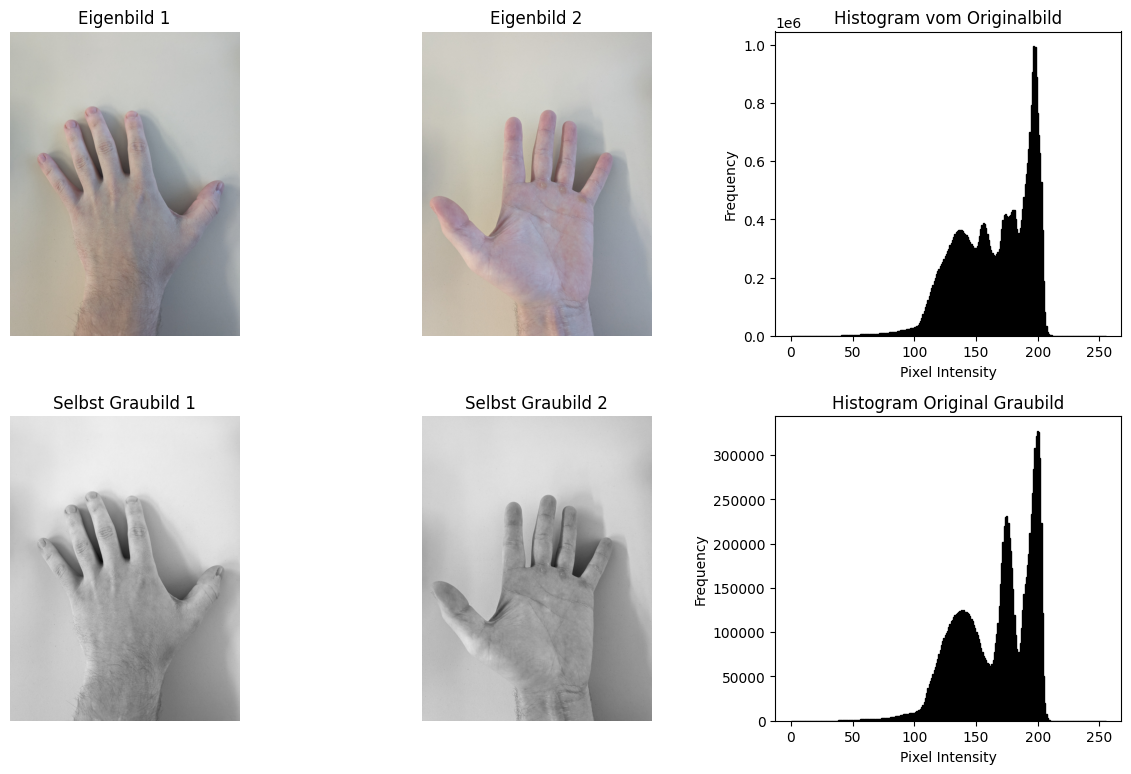

In [15]:
# Bilder einlesen
image1 = 'Hand1.jpg'
image2 = 'Hand2.jpg'
img1 = cv2.imread(image1)
img2 = cv2.imread(image2)

# BGR zu RGB konvertieren für korrekte Darstellung
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Bilder in Graustufen umwandeln
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Plot erstellen
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Originalbild 1 im plot anzeigen
axs[0, 0].imshow(img1_rgb)
axs[0, 0].set_title('Eigenbild 1')
axs[0, 0].axis('off')


# Originalbild 2 im plot anzeigen
axs[0, 1].imshow(img2_rgb)
axs[0, 1].set_title('Eigenbild 2')
axs[0, 1].axis('off')

# Graustufenbild 1  im plot anzeigen
axs[1, 0].imshow(img1_gray, cmap='gray')
axs[1, 0].set_title('Selbst Graubild 1')
axs[1, 0].axis('off')

# Graustufenbild 2 im plot anzeigen
axs[1, 1].imshow(img2_gray, cmap='gray')
axs[1, 1].set_title('Selbst Graubild 2')
axs[1, 1].axis('off')

# Histogramm des OG Bildes im plot anzeigen
axs[0, 2].hist(img1_rgb.flatten(), bins=256, range=(0, 255), color='black', edgecolor='black')
axs[0, 2].set_title('Histogram vom Originalbild')
axs[0, 2].set_xlabel('Pixel Intensity')
axs[0, 2].set_ylabel('Frequency')

# Histogramm des Graustufenbildes im plot anzeigen
axs[1, 2].hist(img1_gray.flatten(), bins=256, range=(0, 255), color='black', edgecolor='black')
axs[1, 2].set_title('Histogram Original Graubild')
axs[1, 2].set_xlabel('Pixel Intensity')
axs[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

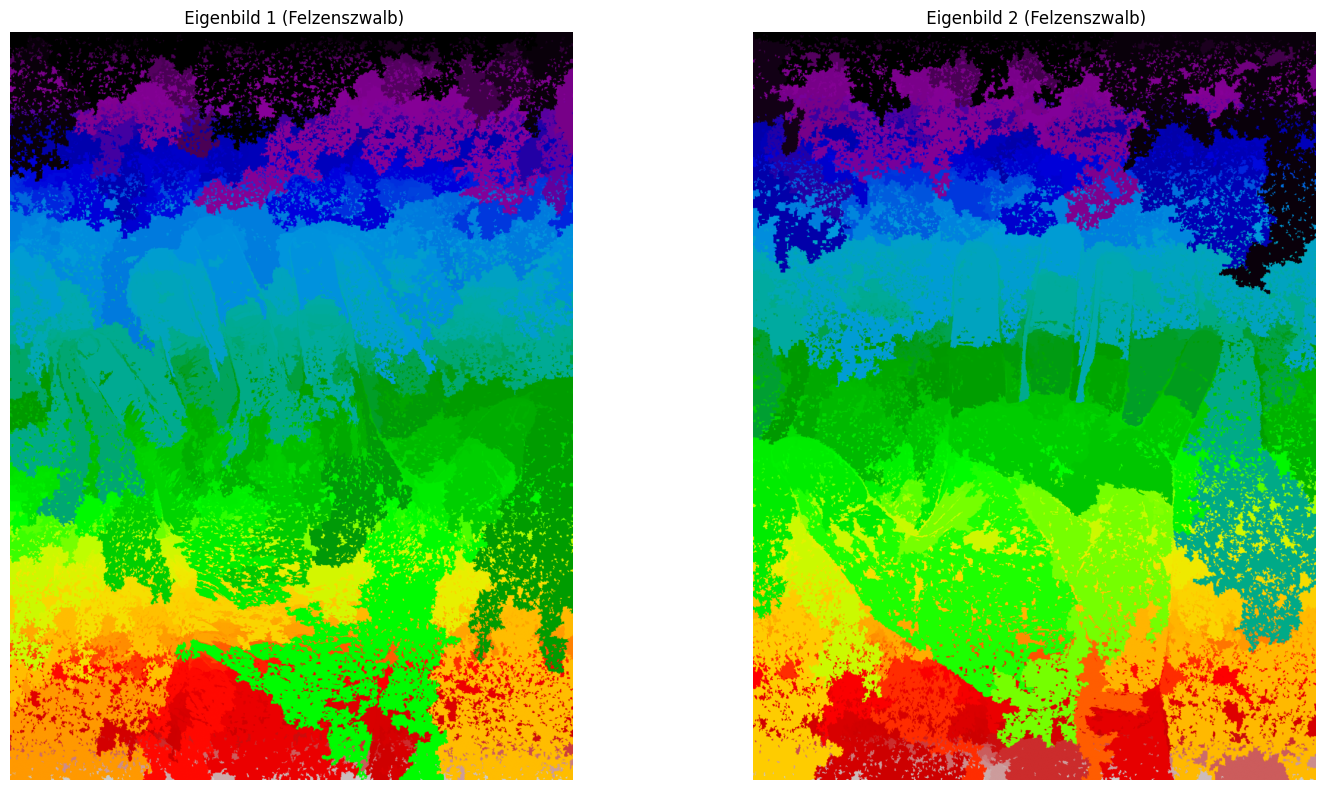

In [16]:
#Segmentierung mit Felsenzwalb

#Felsenzwalb Einlesung 1
img1_float = img_as_float(img1_rgb)
segments1 = felzenszwalb(img1_float, scale=100, sigma=0.5, min_size=50)

#Felsenzwalb Einlesung 2
img2_float = img_as_float(img2_rgb)
segments2 = felzenszwalb(img2_float, scale=100, sigma=0.5, min_size=50)

# Kleinen Plot erstellen
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Segmentierte Bilder im Plot anzeigen
axs[0].imshow(segments1, cmap='nipy_spectral')
axs[0].set_title(' Eigenbild 1 (Felzenszwalb)')
axs[0].axis('off')

axs[1].imshow(segments2, cmap='nipy_spectral')
axs[1].set_title(' Eigenbild 2 (Felzenszwalb)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
 #GLCM-Feature Extraction Funktions - Block

 #Die Sachen oben waren nur zur Schau. Jetzt geht es richtig los.


#GLCM Extractor Block für contrast, dissimilarity, homogeneity, energy, correlation, ASM
def extract_glcm_features(gray_img):
    glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    return contrast, dissimilarity, homogeneity, energy, correlation, ASM

#Als erstes habe ich die Bilder *En-Masse'* mit einer for-Schleife geladen um mir 80 Bilder manuell einladen sparen kann.


#Image folder auf Content setzen, weil da die ganzen Bilder drinnen sind
image_folder = '/content/'
image_data_list = [] # Neue Liste für die Image Daten
features_list = [] # Liste für die Features für Kmeans

#Eigentlicher Loop
for filename in os.listdir(image_folder):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        # Bild einlesen und in Graustufen umwandeln
        img = cv2.imread(os.path.join(image_folder, filename))
        img_gray = rgb2gray(img)  # Konvertiere in Graustufen
        img_gray = (img_gray * 255).astype(np.uint8)  # Skaliere zurück auf 8-Bit

        # GLCM Features extrahieren
        contrast, dissimilarity, homogeneity, energy, correlation, ASM = extract_glcm_features(img_gray)

        # Speichern der Features in der Liste
        features_list.append([filename, contrast, dissimilarity, homogeneity, energy, correlation, ASM])
        image_data_list.append(filename)  # Daten lagern


# Ergebnis als Pandas DataFrame speichern; einfach damit man auf einen Blick sieht wie viele Bilder man hat
# Ich kriege es nicht hin die 7 Wichtigen Features auf eine seite zu bekommen. Es ist halt auf 2 Seiten verteilt in der show unten.
features_df = pd.DataFrame(features_list, columns=['Filename', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM'])

# Zeige die extrahierten Features
print(features_df)


# GLCM-Features berechnen für die beiden Originalbilder
features_img1 = extract_glcm_features(img1_gray)
features_img2 = extract_glcm_features(img2_gray)


# Erstellen der eigentlichen Tabelle mit den GLCM-Features
data = {
    'Feature': ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM'],
    'Image 1': [features_img1[0], features_img1[1], features_img1[2], features_img1[3], features_img1[4], features_img1[5]],
    'Image 2': [features_img2[0], features_img2[1], features_img2[2], features_img2[3], features_img2[4], features_img2[5]]
}

# DataFrame erstellen
df = pd.DataFrame(data)

# Schöne Tabelle bauen
styled_df = df.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#f5f5f5'), ('border', '1px solid black'), ('padding', '8px')]},
     {'selector': 'tbody td', 'props': [('border', '1px solid black'), ('padding', '8px')]},
     {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
     {'selector': 'thead', 'props': [('font-weight', 'bold')]},
     {'selector': 'tbody', 'props': [('background-color', '#fafafa')]}]
)

# Tabelle anzeigen
styled_df

                      Filename    Contrast  Dissimilarity  Homogeneity  \
0      IMG-20250107-WA0044.jpg   30.835425       2.591975     0.430937   
1                    Jons2.jpg  191.160930       9.847854     0.121689   
2      IMG-20250107-WA0029.jpg   12.360820       0.989874     0.740674   
3      IMG-20250107-WA0062.jpg   33.128582       2.893143     0.439206   
4      IMG-20250107-WA0042.jpg   12.721329       1.803443     0.529795   
..                         ...         ...            ...          ...   
59     IMG-20250107-WA0053.jpg   31.654053       1.901395     0.584666   
60  PXL_20250107_113143334.jpg    5.732247       1.589038     0.487897   
61     IMG-20250107-WA0055.jpg   51.098417       3.789416     0.304728   
62     IMG-20250107-WA0048.jpg   23.382505       1.392407     0.717620   
63     IMG-20250107-WA0049.jpg    2.393272       0.474010     0.847578   

      Energy  Correlation       ASM  
0   0.039064     0.994832  0.001526  
1   0.013685     0.946612  0.000187

,Feature,Image 1,Image 2
0,Contrast,4.811131,5.872817
1,Dissimilarity,1.440606,1.594831
2,Homogeneity,0.511281,0.485943
3,Energy,0.048074,0.050345
4,Correlation,0.997264,0.994786
5,ASM,0.002311,0.002535


KMean Start

Cluster-Zuweisungen für jedes Bild:
                      Filename    Contrast  Dissimilarity  Homogeneity  \
0      IMG-20250107-WA0044.jpg   30.835425       2.591975     0.430937   
1                    Jons2.jpg  191.160930       9.847854     0.121689   
2      IMG-20250107-WA0029.jpg   12.360820       0.989874     0.740674   
3      IMG-20250107-WA0062.jpg   33.128582       2.893143     0.439206   
4      IMG-20250107-WA0042.jpg   12.721329       1.803443     0.529795   
..                         ...         ...            ...          ...   
59     IMG-20250107-WA0053.jpg   31.654053       1.901395     0.584666   
60  PXL_20250107_113143334.jpg    5.732247       1.589038     0.487897   
61     IMG-20250107-WA0055.jpg   51.098417       3.789416     0.304728   
62     IMG-20250107-WA0048.jpg   23.382505       1.392407     0.717620   
63     IMG-20250107-WA0049.jpg    2.393272       0.474010     0.847578   

      Energy  Correlation       ASM  Cluster  
0   0.039064     0.994832  0

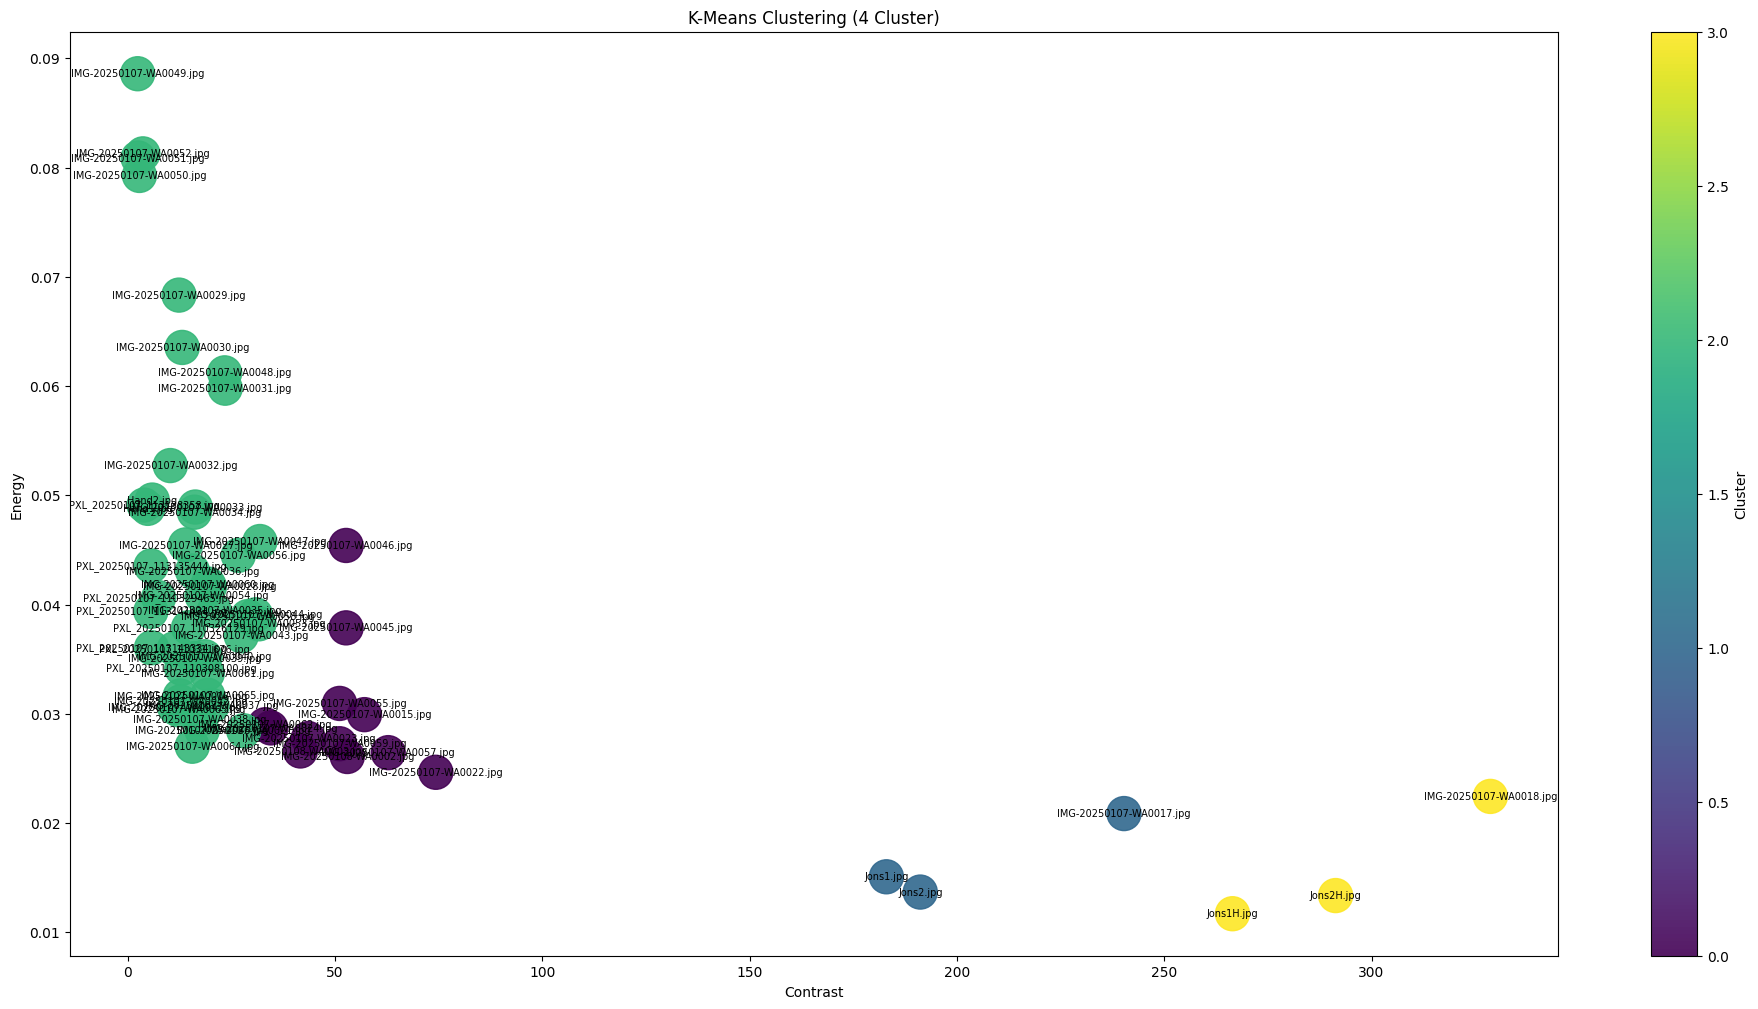

In [17]:
# Jetzt geht es daran, die Features von der GLCM (bzw den Bildern), die von der GLCM extrahiert worden sind im Kmeans darzustellen und
# zu veranschaulichen.

# Hierzu laden wir als erstes die df_features (Featurelist von GLCM) ein und bauen uns damit ein DataFrame welches von Kmeans genutzt werden kann.
df_features = pd.DataFrame(features_list, columns=['Filename', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM'])


# Hier kann ich nicht viel zu sagen, ist halt Kmean- Clustering, wir nehmen 4 Cluster zum Unterteilen
kmeans = KMeans(n_clusters=4, random_state=42)

df_features['Cluster'] = kmeans.fit_predict(df_features[['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM']])


# Ausgabe der Clusterergebnisse
print("Cluster-Zuweisungen für jedes Bild:")
print(df_features)

# Visualisierung der Cluster mit Farben
plt.figure(figsize=(24, 12))

# Hier werden die Farben für die Cluster festgelegt
plt.scatter(df_features['Contrast'], df_features['Energy'], c=df_features['Cluster'], cmap='viridis', s=600, alpha=0.9)
plt.xlabel('Contrast')
plt.ylabel('Energy')
plt.title('K-Means Clustering (4 Cluster)')
# Hier wird die Farbskala (Colorbar) hinzugefügt
plt.colorbar(label='Cluster')

# Anzeigen der Dateinamen als Beschriftungen der Punkte
for i, row in df_features.iterrows():
    plt.text(row['Contrast'], row['Energy'], row['Filename'], fontsize=7, ha='center', va='center')

plt.show()

Nachdem ich jetzt die GLCM Merkmale extrahiert und mithilfe von K-Means Cluster analysiert habe, habe ich vieles offen.

Die Frage ist, wofür kann ich es anwenden, was immernoch im Scope eines Studenten ist, aber nicht zu viel Ressourcen / Coding Mastery benötigt.

Zuordnung von Bildern in Cluster habe ich wie oben gesehen schon gemacht. Daraus könnte man Bilder gruppieren, die ähnliche Textureigenschaften aufweisen.

Mit weiteren Bildern die hinzugefügt werden könnte man also prüfen, ob sie ähnliche Textureigenschaften ausfweisen innerhalb des Clusters.

Das interessanteste meiner Meinung nach wäre Anomalieerkennung. Wenn ich also  Bilder identifizieren würde, die nicht gut in eines der Cluster passen, um potenziell abnormale Muster oder interessante Texturen zu finden, wäre das eine sehr gut Aufgabe. Nur leider komplett aus meinem Scope draussen.

Also habe ich mich dafür entschieden die Cluster zu benennen und eine Visuelle Repräsentation zu machen.



Cluster
0    12
1     3
2    46
3     3
Name: count, dtype: int64
Cluster
2    46
0    12
1     3
3     3
Name: count, dtype: int64


<ipython-input-27-89baf2ea3ade>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', 4)  # 4 Farben für 4 Cluster


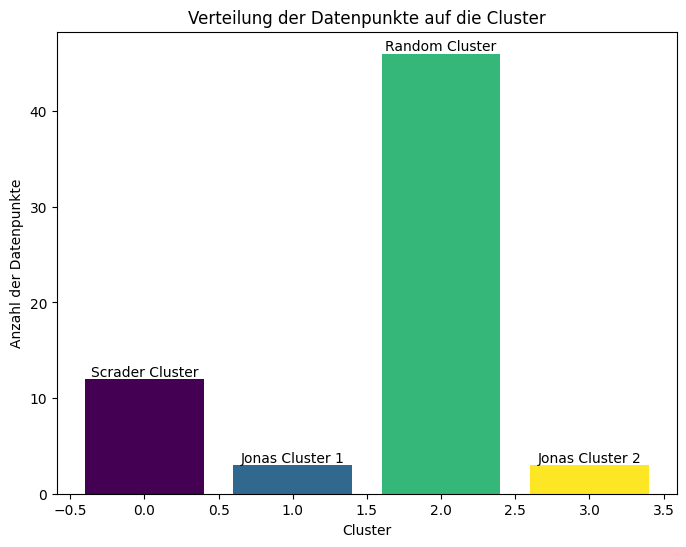

In [27]:
# Mit cluster_count zählt man die Anzhal und anschließend wie viele
# Bilder in den Clustern vorhanden sind
cluster_counts = df_features['Cluster'].value_counts().sort_index()
print(cluster_counts)

cluster_counts = df_features['Cluster'].value_counts().sort_values(ascending=False)
print(cluster_counts)


plt.figure(figsize=(8, 6))

# Farbpalette laden um die gleichen Farben wie auf der Kmeans Map zu haben.
cmap = cm.get_cmap('viridis', 4)  # 4 Farben für 4 Cluster

# Balken mit den entsprechenden Farben erstellen
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=[cmap(i) for i in cluster_counts.index])

plt.xlabel('Cluster')
plt.ylabel('Anzahl der Datenpunkte')
plt.title('Verteilung der Datenpunkte auf die Cluster')

# Clusternamen definieren
cluster_names = {
    0: 'Schrader Cluster',
    1: 'Jonas Cluster 1',
    2: 'Random Cluster',
    3: 'Jonas Cluster 2'
}

# Namen auf den Balken werfen
for bar in bars:
    cluster_id = int(bar.get_x() + bar.get_width() / 2)
    cluster_count = int(bar.get_height())
    plt.text(cluster_id, cluster_count, cluster_names[cluster_id], ha='center', va='bottom')

plt.show()

Sie können einige verschiedene Merkmale auf den Bildern sehen weshalb sie von Kmeans anders eingestuft worden sind. Man kann eine Klare absonderung von Jonas seinen Bildern sehen da diese sowohl einen anderen Hintergrund, sowohl andere Merkmale haben.

Mit dieser letzten Anmerkung kommt meine Aufgabe zuende, ich hoffe es hat ihnen Gefallen.